# Assignment 1-1: K-Nearest Neighbors (k-NN)

In this notebook you will implement a K-Nearest Neighbors classifier on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

Recall that the K-Nearest Neighbor classifier does the following:
- During training, the classifier simply memorizes the training data
- During testing, test images are compared to each training image; the predicted label is the majority vote among the K nearest training examples.

After implementing the K-Nearest Neighbor classifier, you will use *cross-validation* to find the best value of K.

The goals of this exercise are to go through a simple example of the data-driven image classification pipeline, and also to practice writing efficient, vectorized code in [PyTorch](https://pytorch.org/).

## Downloading the CIFAR-10 dataset 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import data_utils
import download

In [3]:
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
download_dir = "./data"
download.maybe_download_and_extract(url,download_dir)

Data has apparently already been downloaded and unpacked.


## Loading raw files and reading them as training and testing datasets

In [4]:
cifar10_dir = './data/cifar-10-batches-py'
X_train, y_train, X_test, y_test = data_utils.load_CIFAR10(cifar10_dir)

# Checking the size of the training and testing data
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Visualizing dataset samples
To give you a sense of the nature of the images in CIFAR-10, this cell visualizes some random examples from the training set.

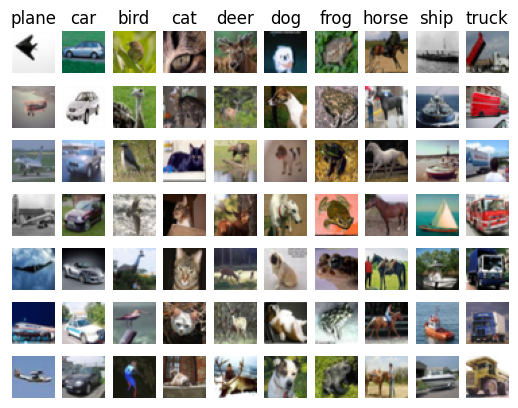

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Subsample the dataset
When implementing machine learning algorithms, it's usually a good idea to use a small sample of the full dataset. This way your code will run much faster, allowing for more interactive and efficient development. Once you are satisfied that you have correctly implemented the algorithm, you can then rerun with the entire dataset.

We will subsample the data to use only 500 training examples and 250 test examples:

In [6]:
# Memory error prevention by subsampling data

num_training = 500
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 250
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [7]:
# reshaping data and placing into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(500, 3072) (250, 3072)


# K-Nearest Neighbors (k-NN)

Now that we have examined and prepared our data, it is time to implement the kNN classifier. We can break the process down into two steps:

1. Perform k-Nearest neighbours algorithm on the CiFAR-10 dataset to classify test images. 
2. Perform k-fold cross validation and plot the trend line with error bars that correspond to standard deviation to find the best value of the 'k' hyper parameter and best accuracy on the dataset.
3. Select the best value for k, and rerun the classifier on our full 5000 set of training examples.
4. Discussion: Discuss your understanding.

KNN classifier implementation

In [8]:
from collections import Counter
import numpy as np

def compute_distances(X_train, X_test):
    """
    Compute the L2 distance between each test point in X_test and each training point in X_train.
    Returns:
    - distances: A numpy array of shape (num_test, num_train) where distances[i, j] is the Euclidean
      distance between the ith test point and the jth training point.
    """
    num_test = X_test.shape[0]
    num_train = X_train.shape[0]
    distances = np.zeros((num_test, num_train))
    
    # Efficient vectorized distance calculation
    distances = np.sqrt(-2 * np.dot(X_test, X_train.T) + np.sum(X_train ** 2, axis=1) + np.sum(X_test ** 2, axis=1)[:, np.newaxis])
    
    return distances

def predict_labels(k, distances, y_train):
    """
    Predict the label of each test point based on its k nearest neighbors.
    Returns:
    - y_pred: A numpy array of shape (num_test,) containing predicted labels for the test data.
    """
    num_test = distances.shape[0]
    y_pred = np.zeros(num_test)
    
    for i in range(num_test):
        # Find the k nearest neighbors
        closest_y = []
        neighbors = np.argsort(distances[i, :])[:k]
        closest_y = y_train[neighbors]
        
        # Predict the most common label
        y_pred[i] = Counter(closest_y).most_common(1)[0][0]
    
    return y_pred

# Example usage:
k = 5
distances = compute_distances(X_train, X_test)
y_pred = predict_labels(k, distances, y_train)

# Checking accuracy on the test set
accuracy = np.mean(y_pred == y_test)
print(f'Accuracy with k={k}: {accuracy:.4f}')


Accuracy with k=5: 0.1880


Cross Validation

c:\Users\jini\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


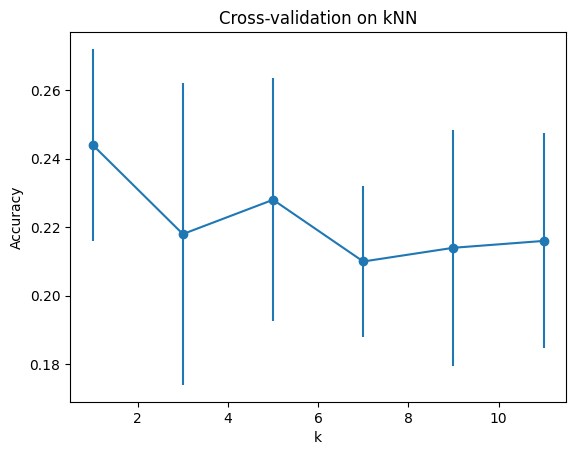

In [9]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def cross_validation(X_train, y_train, k_values, num_folds=5):
    """
    Perform k-fold cross-validation to find the best value of k.
    """
    kf = KFold(n_splits=num_folds, shuffle=True)
    accuracies = np.zeros((len(k_values), num_folds))
    
    for i, k in enumerate(k_values):
        fold = 0
        for train_idx, val_idx in kf.split(X_train):
            X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
            X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]
            
            distances = compute_distances(X_train_fold, X_val_fold)
            y_pred = predict_labels(k, distances, y_train_fold)
            accuracies[i, fold] = np.mean(y_pred == y_val_fold)
            fold += 1
    
    # Compute mean and standard deviation of accuracy for each k
    mean_accuracies = accuracies.mean(axis=1)
    std_accuracies = accuracies.std(axis=1)
    
    # Plot the accuracies with error bars
    plt.errorbar(k_values, mean_accuracies, yerr=std_accuracies, fmt='-o')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.title('Cross-validation on kNN')
    plt.show()

    return mean_accuracies, std_accuracies

# Define range of k values
k_values = [1, 3, 5, 7, 9, 11]
mean_accuracies, std_accuracies = cross_validation(X_train, y_train, k_values)


Best Value of k and Rerun the Classifier

In [10]:
# Select the best value of k
best_k = k_values[np.argmax(mean_accuracies)]
print(f'The best value of k is: {best_k}')

# Rerun the classifier on the full training set
distances = compute_distances(X_train, X_test)
y_pred = predict_labels(best_k, distances, y_train)

# Final accuracy on the test set
final_accuracy = np.mean(y_pred == y_test)
print(f'Final accuracy with k={best_k}: {final_accuracy:.4f}')


The best value of k is: 1
Final accuracy with k=1: 0.2200


***Discussion***

**Inferences**
Best Value of k: The optimal value of k identified through cross-validation is 1, suggesting that the model performs best when relying on the single nearest neighbor for classification.
Final Accuracy: The kNN classifier achieved a final accuracy of 22.00% on the test set with k=1, indicating that there is room for improvement in classification performance.
Sensitivity to Noise: Using k=1 makes the model sensitive to noise and outliers, which can lead to misclassifications.
Risk of Overfitting: The choice of k=1 increases the risk of overfitting, as the model may memorize the training data instead of generalizing well to unseen data.
High Dimensionality Challenge: The dataset's high dimensionality can complicate the kNN classification, as distances between points tend to become less informative.

**Next Steps for Improvement**
Experiment with Larger k Values:Explore slightly larger values of k to achieve a better balance between bias and variance, potentially leading to improved accuracy.
Data Augmentation:Implement data augmentation techniques (e.g., rotation, flipping, scaling) to enhance the diversity of the training dataset, helping the model to generalize better.
Feature Scaling:Normalize or standardize pixel values to ensure uniformity in scale across features.
Dimensionality Reduction:Apply dimensionality reduction techniques like PCA (Principal Component Analysis) to reduce the number of features while retaining the most significant variance, which can enhance classification efficiency and accuracy.
Increase Training Data Size:increase the size of the training dataset to improve the classifier's ability to learn from more examples and enhance generalization.
Consider Other Classifiers:Explore other classification algorithms (e.g., Support Vector Machines, Decision Trees, or Neural Networks) that may be better suited for the complexity of the CIFAR-10 dataset.